In [1]:
from fraggler import fraggler

[INFO]: Starting fraggler, importing libraries...


## Fsa file object

Start with creating a fsa object:

In [2]:
fsa = fraggler.FsaFile(
    file="multiplex.fsa",
    ladder="LIZ",
    sample_channel="DATA1",
    min_distance_between_peaks=30,
    min_size_standard_height=100
)


## Fitting the size standard to the ladder

Here we find the size standard peaks from the identified size standard channel

In [3]:
fsa = fraggler.find_size_standard_peaks(fsa)

To find the correct combinations of peaks from the size standard data, we have to estimate a good distance between peaks to limit the amount of combinations that can be generated. With the below function, be calculate the mean length between each peak and multiplies that with the value of the multiplier

In [4]:
fsa = fraggler.return_maxium_allowed_distance_between_size_standard_peaks(
    fsa, multiplier=2
)
    
fsa.maxium_allowed_distance_between_size_standard_peaks

270

Here, we generate all possible combinations using the diff value calculated above and a depth first search algorithm. 

In [5]:
fsa = fraggler.generate_combinations(fsa)
fsa.best_size_standard_combinations

,combinations
0,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
1,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
2,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
3,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
4,"[1020, 1151, 1263, 1407, 1561, 1721, 1834, 188..."
...,...
139,"[1151, 1263, 1407, 1561, 1721, 1834, 1884, 205..."
140,"[1151, 1263, 1407, 1561, 1721, 1834, 2054, 222..."
141,"[1151, 1263, 1407, 1561, 1721, 1884, 2054, 222..."
142,"[1151, 1407, 1561, 1721, 1834, 1884, 2054, 222..."


Next, using the second derivative, we identifies which of all combinations fits the ladder steps the best 

In [6]:
fsa = fraggler.calculate_best_combination_of_size_standard_peaks(fsa)


fsa.best_size_standard

array([1151, 1263, 1407, 1561, 1721, 1834, 1884, 2054, 2221, 2391, 2562,
       2683, 2735, 2911, 3086, 3262, 3441, 3566, 3618, 3796, 3973, 4150,
       4324, 4447, 4498, 4669, 4836, 5002, 5161, 5270, 5316, 5469, 5614,
       5753, 5887])

Using the best size standard from above, we fit a model using the ladder steps

In [7]:
fsa = fraggler.fit_size_standard_to_ladder(fsa)

fsa.ladder_model

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(degree=2, extrapolation='continue',
                                   n_knots=3)),
                ('linearregression', LinearRegression())])

In [8]:
print(fsa.ladder_model.steps[1][1].coef_)
print(fsa.ladder_model.steps[1][1].intercept_)

[-443.25627683 -129.41587151  124.55183409  448.12031426]
310.95458893524136


The fitted model is used to convert time to basepairs in the sample data channel

In [9]:
fsa.sample_data_with_basepairs

,time,peaks,basepairs
967,967,302,0.05
968,968,312,0.19
969,969,340,0.32
970,970,377,0.45
971,971,425,0.59
...,...,...,...
6599,6599,1,697.73
6600,6600,6,697.87
6601,6601,5,698.02
6602,6602,7,698.16


## Use the `fit_ladder` function

Or, you can use the helper function `fit_ladder` to do all above in one step

In [10]:
fsa = fraggler.fit_ladder(fsa)

In [11]:
fsa


        Filename: multiplex.fsa
        Sample Channel: DATA1
        Size Standard Channel: DATA205
        Ladder Name: LIZ
        Number of Ladder Steps: 35
        Minimum Distance Between Peaks: 30
        Minimum Size Standard Height: 100
        Normalized Data: False
        Ladder Steps: [ 20  40  60  80 100 114 120 140 160 180 200 214 220 240 260 280 300 314
 320 340 360 380 400 414 420 440 460 480 500 514 520 540 560 580 600]
        Fitted to model: True
        Found peaks: False
        Size Standard Peaks: [1020 1151 1263 1407 1561 1721 1834 1884 2054 2221 2391 2562 2683 2735
 2911 2997 3086 3262 3441 3566 3618 3796 3973 4150 4324 4447 4498 4669
 4836 5002 5161 5270 5316 5469 5614 5753 5887]
        Maximum Allowed Distance Between Size Standard Peaks: 270
        Best Size Standard Combinations:                                           combinations
0    [1020, 1151, 1263, 1407, 1561, 1721, 1834, 188...
1    [1020, 1151, 1263, 1407, 1561, 1721, 1834, 188...
2    [1020

## Find peaks


We can use two modes to find peaks
- agnostic
- custom

### Agnostic peak finding

In [12]:
fsa = fraggler.find_peaks_agnostic(
    fsa,
    peak_height_sample_data=300,
    min_ratio=0.15,
    distance_between_assays=30,
    search_peaks_start=115,
)

In [13]:
fsa.identified_sample_data_peaks

,time,peaks,basepairs,peaks_index,peak_name,difference,assay,max_peak,ratio
2060,2060,782,140.68,207,1,100.00,10,1399,0.558971
2145,2145,1399,151.08,292,2,10.40,10,1399,1.000000
2518,2518,711,195.82,665,3,44.74,30,1548,0.459302
2545,2545,1548,199.00,692,4,3.18,30,1548,1.000000
2807,2807,1601,229.45,954,5,30.45,50,1601,1.000000
2846,2846,969,233.93,993,6,4.48,50,1601,0.605247
3131,3131,1071,266.11,1278,7,32.18,70,2294,0.466870
3160,3160,945,269.33,1307,8,3.22,70,2294,0.411944
3187,3187,459,272.33,1334,9,3.00,70,2294,0.200087
3239,3239,1070,278.07,1386,10,5.74,70,2294,0.466434


### Custom peak finding

The functions below reads and checks if the custom peaks csv is OK.
If there is a problem, the program will tell you.

In [14]:
custom_peaks = fraggler.read_valid_csv("custom_peaks.csv")
fraggler.custom_peaks_are_overlapping(custom_peaks)
fraggler.custom_peaks_has_columns(custom_peaks)

The custom peak table MUST look like this (see more in README):

In [15]:
custom_peaks

,name,start,stop,amount,min_ratio,which,peak_distance
0,prt1,220,240,3,0.2,FIRST,3.0
1,prt2,130,155,2,0.2,FIRST,NaN


Find the peaks using the customized table

In [16]:
fsa = fraggler.find_peaks_customized(
    fsa,
    custom_peaks,
    peak_height_sample_data=200,
    search_peaks_start=115,
)

In [17]:
fsa.identified_sample_data_peaks

,index,time,peaks,basepairs,peaks_index,assay,max_peak,ratio,peak_name
0,2807,2807,1601,229.45,954,prt1,1601,1.000000,1
1,2060,2060,782,140.68,207,prt2,1399,0.558971,2
2,2145,2145,1399,151.08,292,prt2,1399,1.000000,3


## Or, use the helper function `find_peaks` for one step excecution

In [18]:
# using custom peaks
fsa = fraggler.find_peaks(
    fsa, 
    custom_peaks="custom_peaks.csv", 
    peak_height_sample_data=100, 
    search_peaks_start=115,
)

# finding peaks agnostic
fsa = fraggler.find_peaks(
    fsa, 
    peak_height_sample_data=100, 
    search_peaks_start=115,
    min_ratio=0.15,
    distance_between_assays=30
)

### Look at the updated `fsa` object:

In [19]:
fsa


        Filename: multiplex.fsa
        Sample Channel: DATA1
        Size Standard Channel: DATA205
        Ladder Name: LIZ
        Number of Ladder Steps: 35
        Minimum Distance Between Peaks: 30
        Minimum Size Standard Height: 100
        Normalized Data: False
        Ladder Steps: [ 20  40  60  80 100 114 120 140 160 180 200 214 220 240 260 280 300 314
 320 340 360 380 400 414 420 440 460 480 500 514 520 540 560 580 600]
        Fitted to model: True
        Found peaks: agnostic
        Size Standard Peaks: [1020 1151 1263 1407 1561 1721 1834 1884 2054 2221 2391 2562 2683 2735
 2911 2997 3086 3262 3441 3566 3618 3796 3973 4150 4324 4447 4498 4669
 4836 5002 5161 5270 5316 5469 5614 5753 5887]
        Maximum Allowed Distance Between Size Standard Peaks: 270
        Best Size Standard Combinations:                                           combinations
0    [1020, 1151, 1263, 1407, 1561, 1721, 1834, 188...
1    [1020, 1151, 1263, 1407, 1561, 1721, 1834, 188...
2    [1

## Area


Next, we find the areas of the identified peaks

You can choose between the "gauss", "lorentzian" and "voigt" distributions

In [20]:
fsa = fraggler.find_peak_widths(fsa)
fsa = fraggler.find_peaks_with_padding(fsa)
fsa = fraggler.fit_lmfit_model_to_area(fsa, "gauss")

fsa.fitted_area_peaks

,time,peaks,basepairs,assay,peak_name,fitted,model,amplitude,center,sigma,fwhm,fit_report,r_value
2051,2051,31,139.57,10,1,0.000114,gauss,3096.100362,2059.583027,1.527991,3.598144,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2052,2052,23,139.70,10,1,0.003627,gauss,3096.100362,2059.583027,1.527991,3.598144,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2053,2053,18,139.82,10,1,0.075346,gauss,3096.100362,2059.583027,1.527991,3.598144,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2054,2054,13,139.94,10,1,1.019949,gauss,3096.100362,2059.583027,1.527991,3.598144,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
2055,2055,18,140.07,10,1,8.996759,gauss,3096.100362,2059.583027,1.527991,3.598144,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,3272,168,281.71,90,11,123.617533,gauss,10770.784677,3267.559619,1.829871,4.309016,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993
3273,3273,92,281.82,90,11,28.268797,gauss,10770.784677,3267.559619,1.829871,4.309016,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993
3274,3274,60,281.93,90,11,4.795496,gauss,10770.784677,3267.559619,1.829871,4.309016,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993
3275,3275,46,282.04,90,11,0.603474,gauss,10770.784677,3267.559619,1.829871,4.309016,[[Model]]\n Model(gaussian)\n[[Fit Statisti...,0.993


Look at the fit report from the area fit function

In [21]:
print(fsa.fitted_area_peaks.fit_report.iloc[0])

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 17
    # variables        = 3
    chi-square         = 4115.99541
    reduced chi-square = 293.999672
    Akaike info crit   = 99.3201849
    Bayesian info crit = 101.819825
    R-squared          = 0.99640354
[[Variables]]
    amplitude:  3096.10036 +/- 48.8745979 (1.58%) (init = 3460.5)
    center:     2059.58303 +/- 0.02785328 (0.00%) (init = 2059.5)
    sigma:      1.52799106 +/- 0.02785302 (1.82%) (init = 1.5)
    fwhm:       3.59814390 +/- 0.06558884 (1.82%) == '2.3548200*sigma'
    height:     808.359051 +/- 12.7610459 (1.58%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5773


Calculate the quotients between the peaks in each identified assay and update the sample peak table

In [22]:
fsa = fraggler.calculate_quotients(fsa)
fsa = fraggler.update_identified_sample_data_peaks(fsa)

fsa.identified_sample_data_peaks

,time,peaks,basepairs,peaks_index,peak_name,difference,assay,max_peak,ratio,model,r_value,quotient,amplitude
0,2060,782,140.68,207,1,100.00,10,1399,0.558971,gauss,0.996,1.743288,3096.100362
35,2145,1399,151.08,292,2,10.40,10,1399,1.000000,gauss,0.996,1.743288,3096.100362
70,2518,711,195.82,665,3,44.74,30,1548,0.459302,gauss,0.985,2.150498,3117.436078
106,2545,1548,199.00,692,4,1.06,30,1548,1.000000,gauss,0.985,2.150498,3117.436078
142,2807,1601,229.45,954,5,30.45,60,1601,1.000000,gauss,0.996,0.602506,6247.020735
176,2846,969,233.93,993,6,4.48,60,1601,0.605247,gauss,0.996,0.602506,6247.020735
210,3131,1071,266.11,1278,7,30.93,90,2294,0.466870,gauss,0.992,2.852824,4976.181839
300,3160,945,269.33,1307,8,3.22,90,2294,0.411944,gauss,0.992,2.852824,4976.181839
390,3187,459,272.33,1334,9,3.00,90,2294,0.200087,gauss,0.992,2.852824,4976.181839
480,3239,1070,278.07,1386,10,5.74,90,2294,0.466434,gauss,0.992,2.852824,4976.181839


## Or use the helper function `fit_area` to do it in one step:

In [23]:
fsa = fraggler.fit_area(fsa, "gauss")

## Plots

Below are examples of how to plot using fraggler

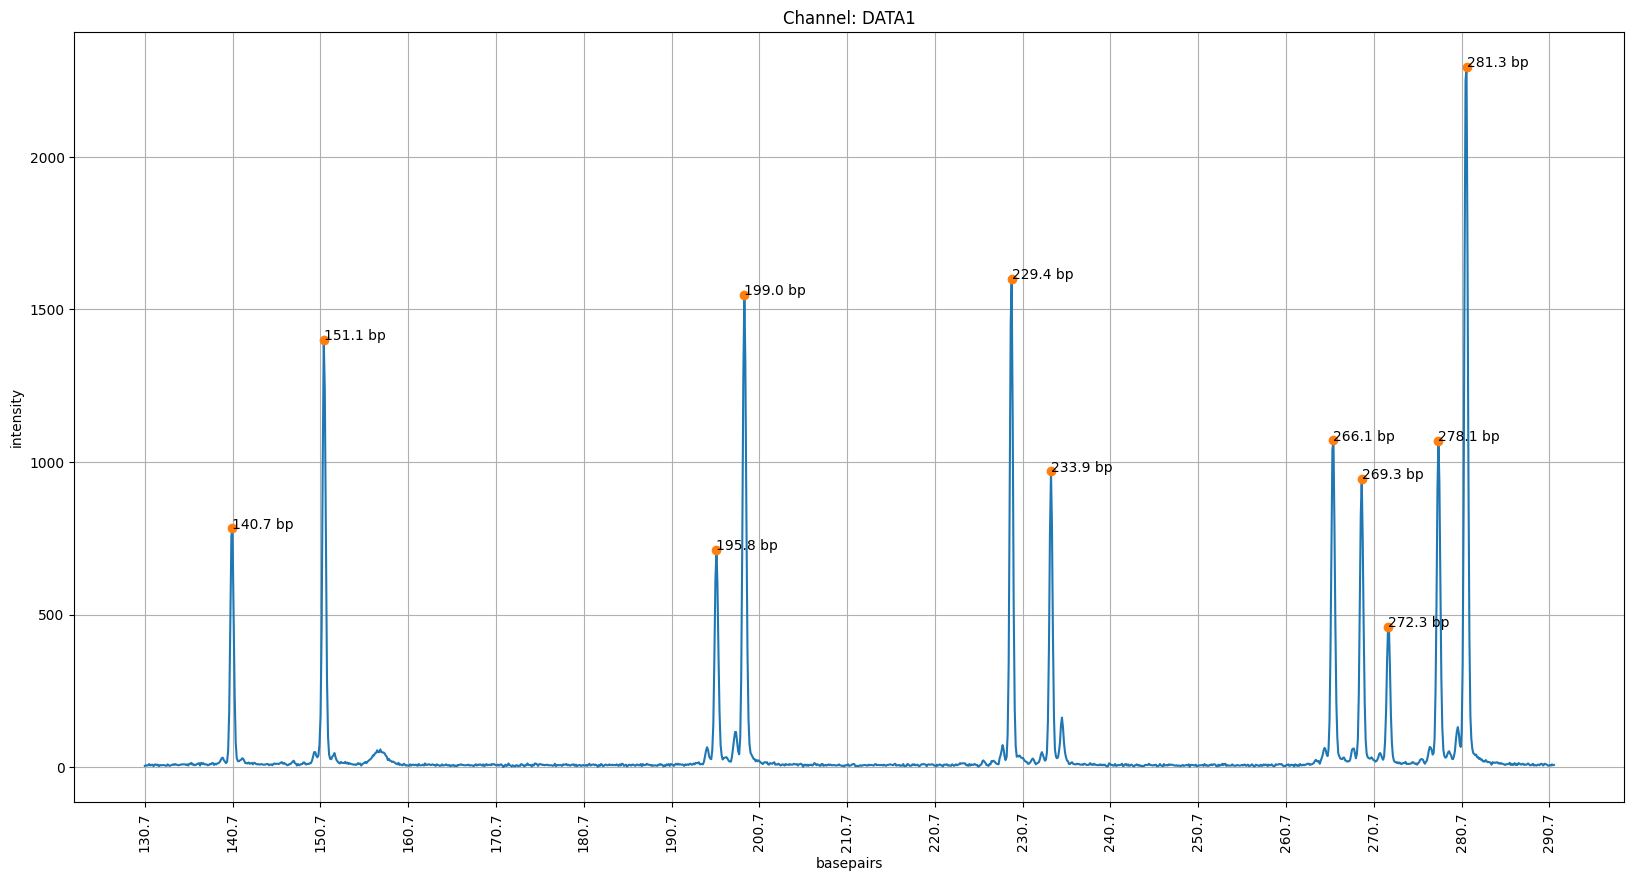

In [24]:
peaks_plot = fraggler.plot_all_found_peaks(fsa)

peaks_plot

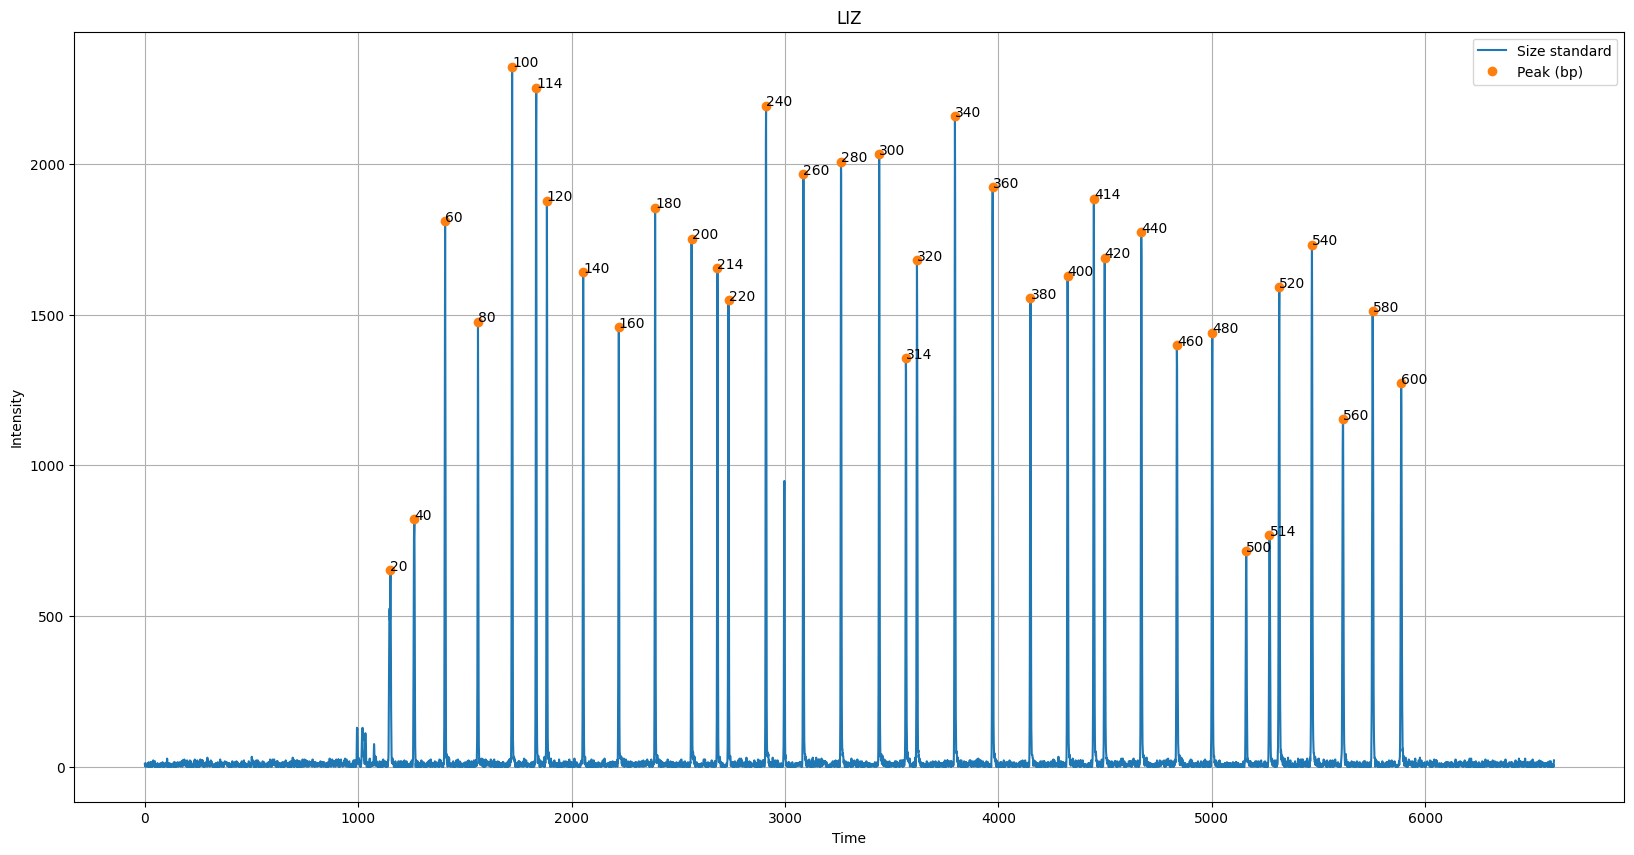

In [25]:
ladder_plot = fraggler.plot_size_standard_peaks(fsa)
ladder_plot

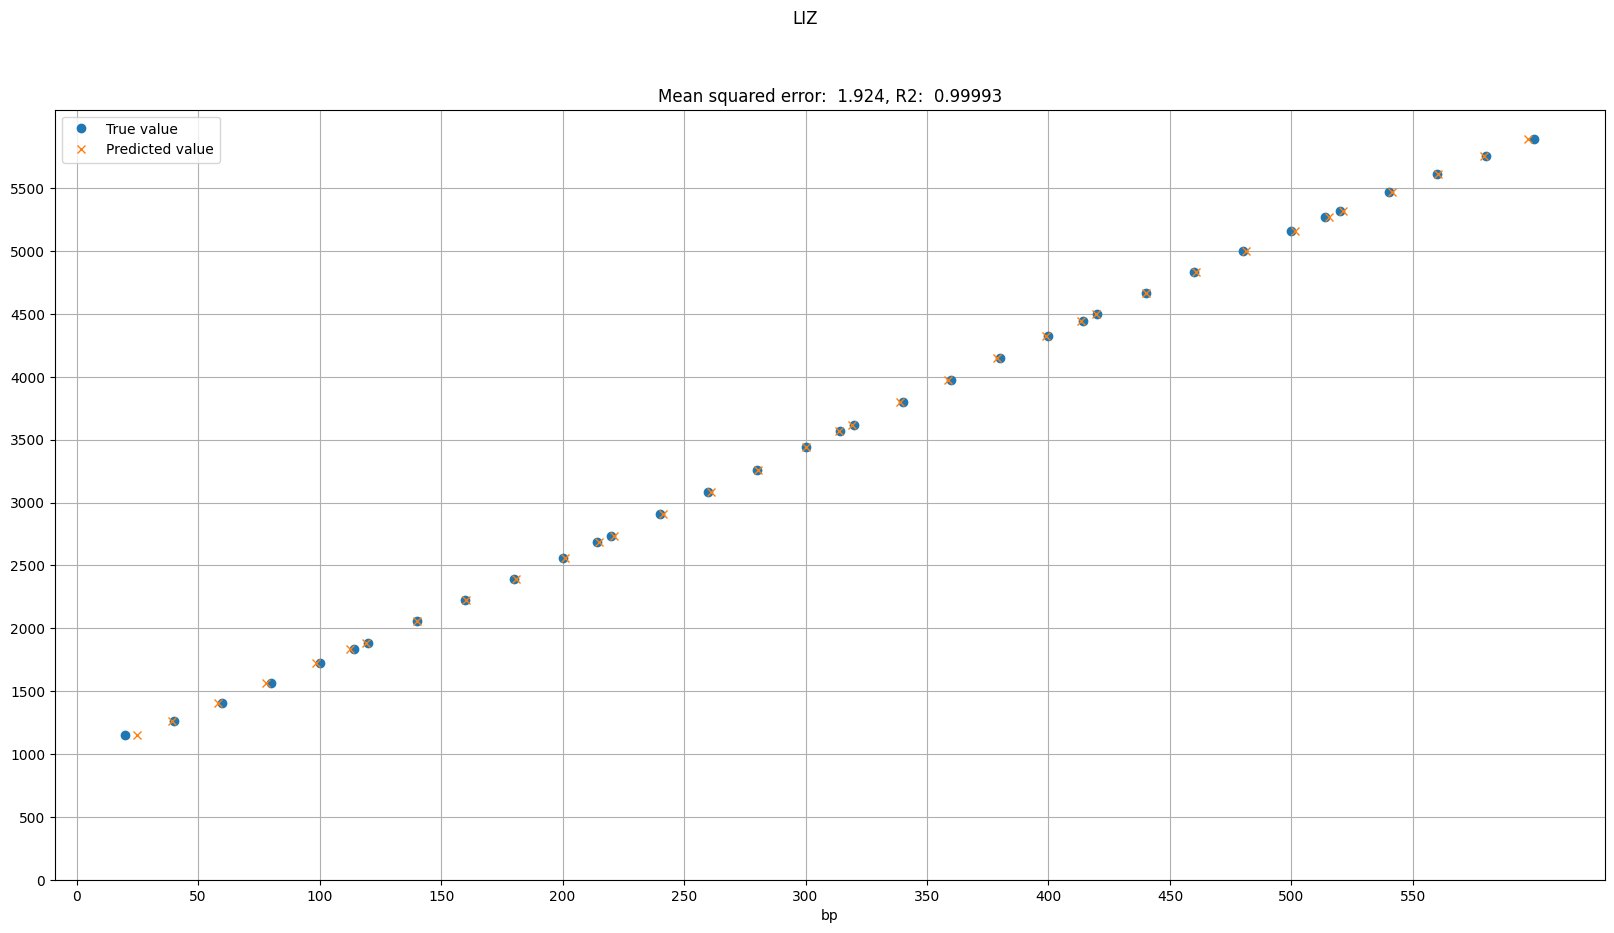

In [26]:
model_fit = fraggler.plot_model_fit(fsa)
model_fit

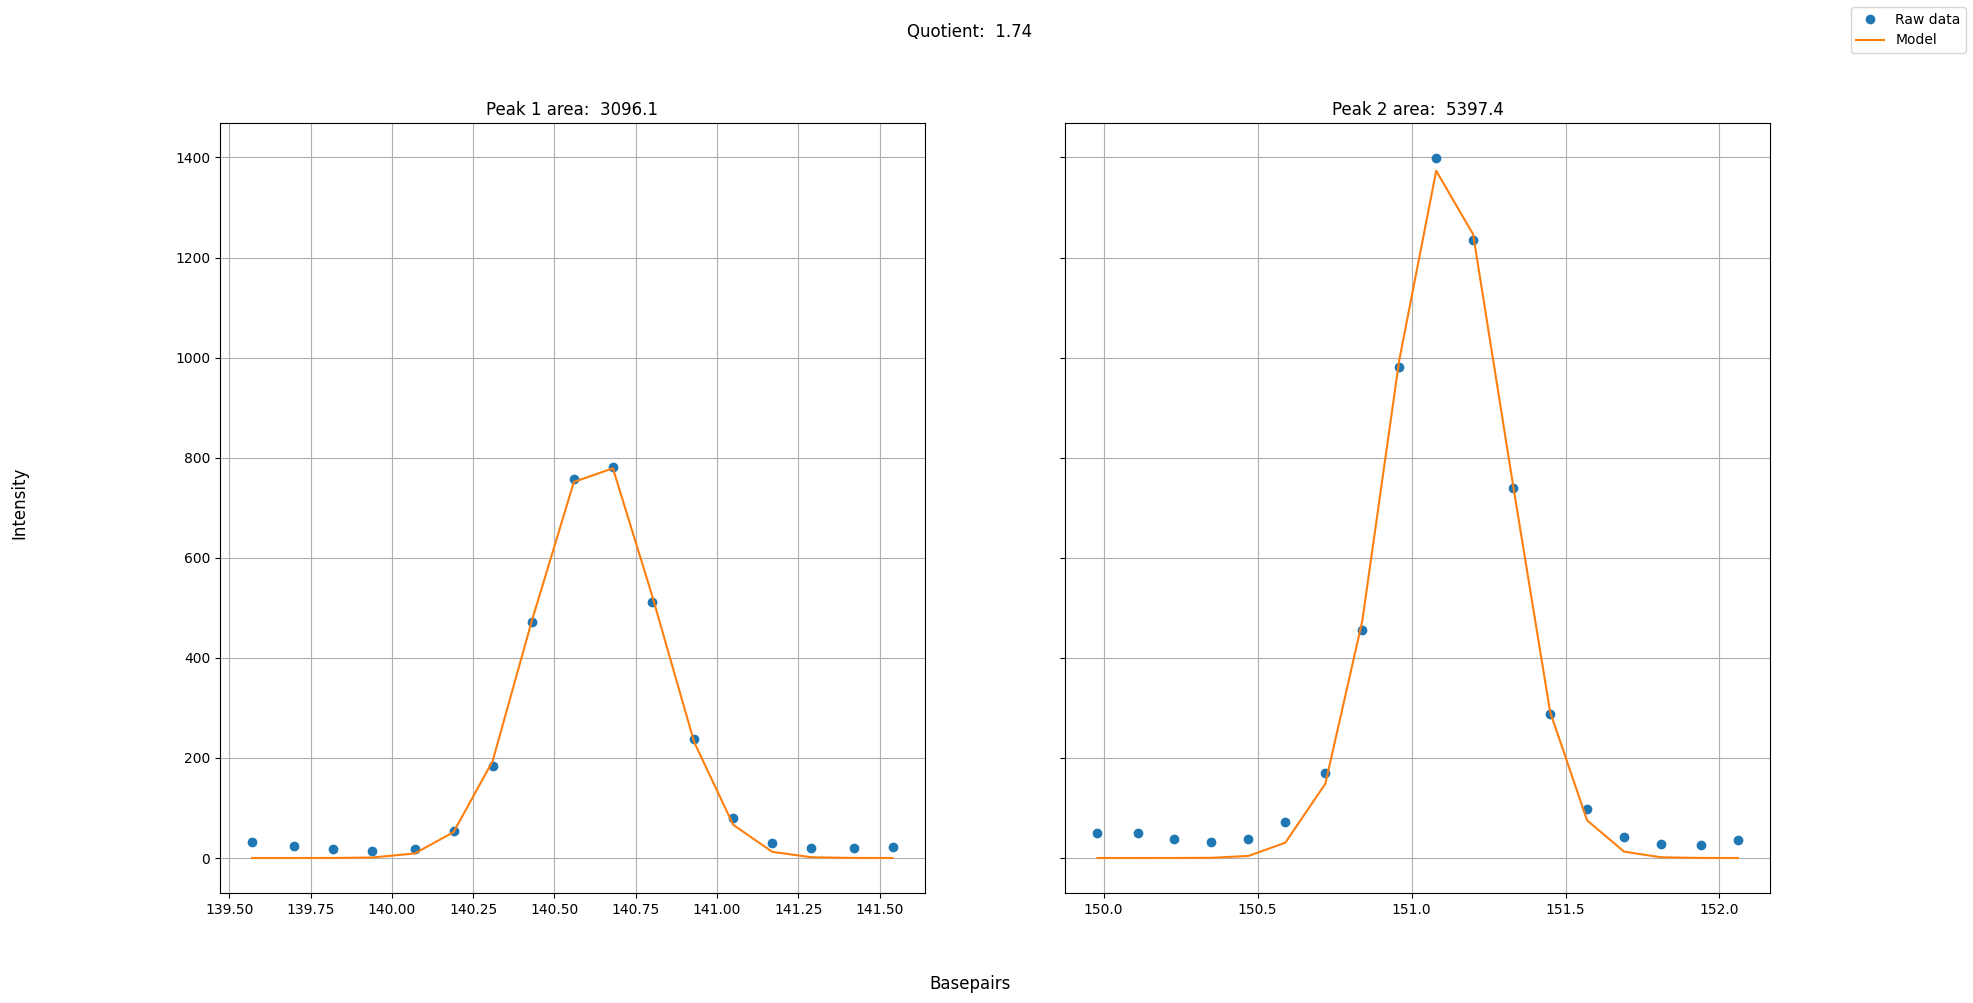

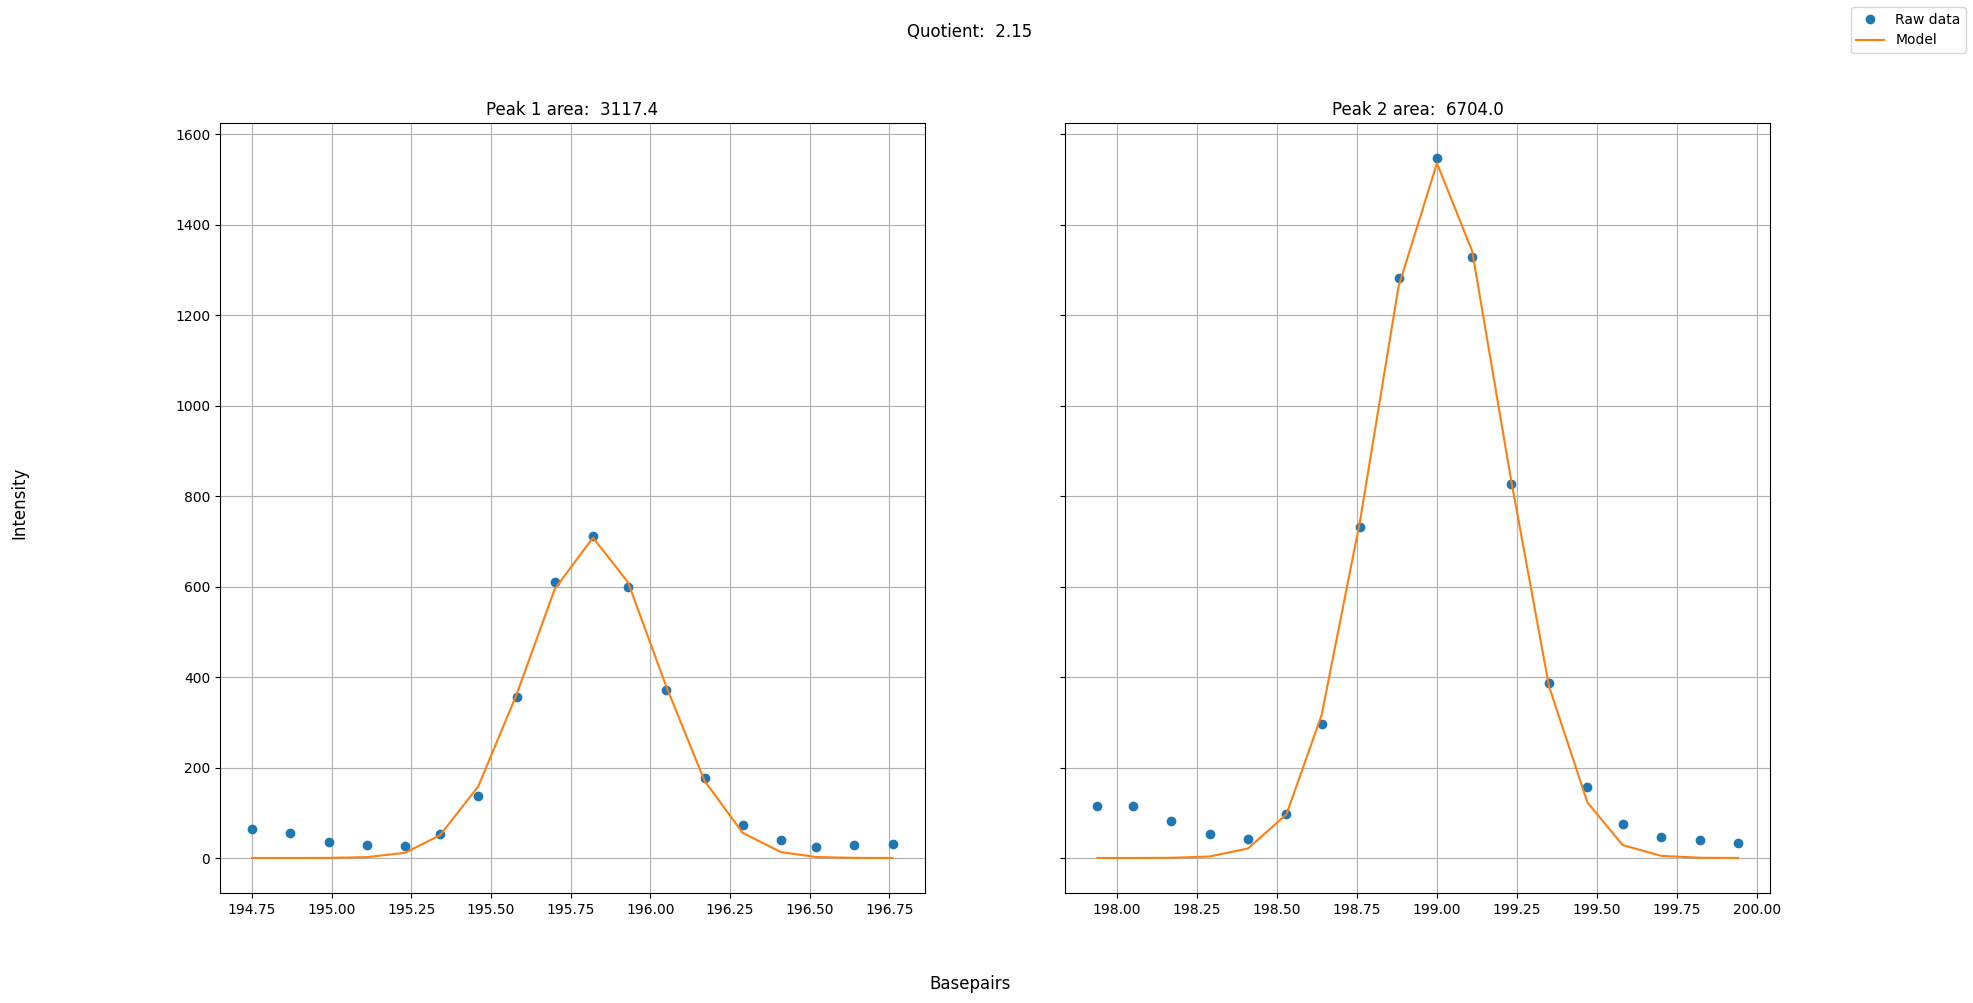

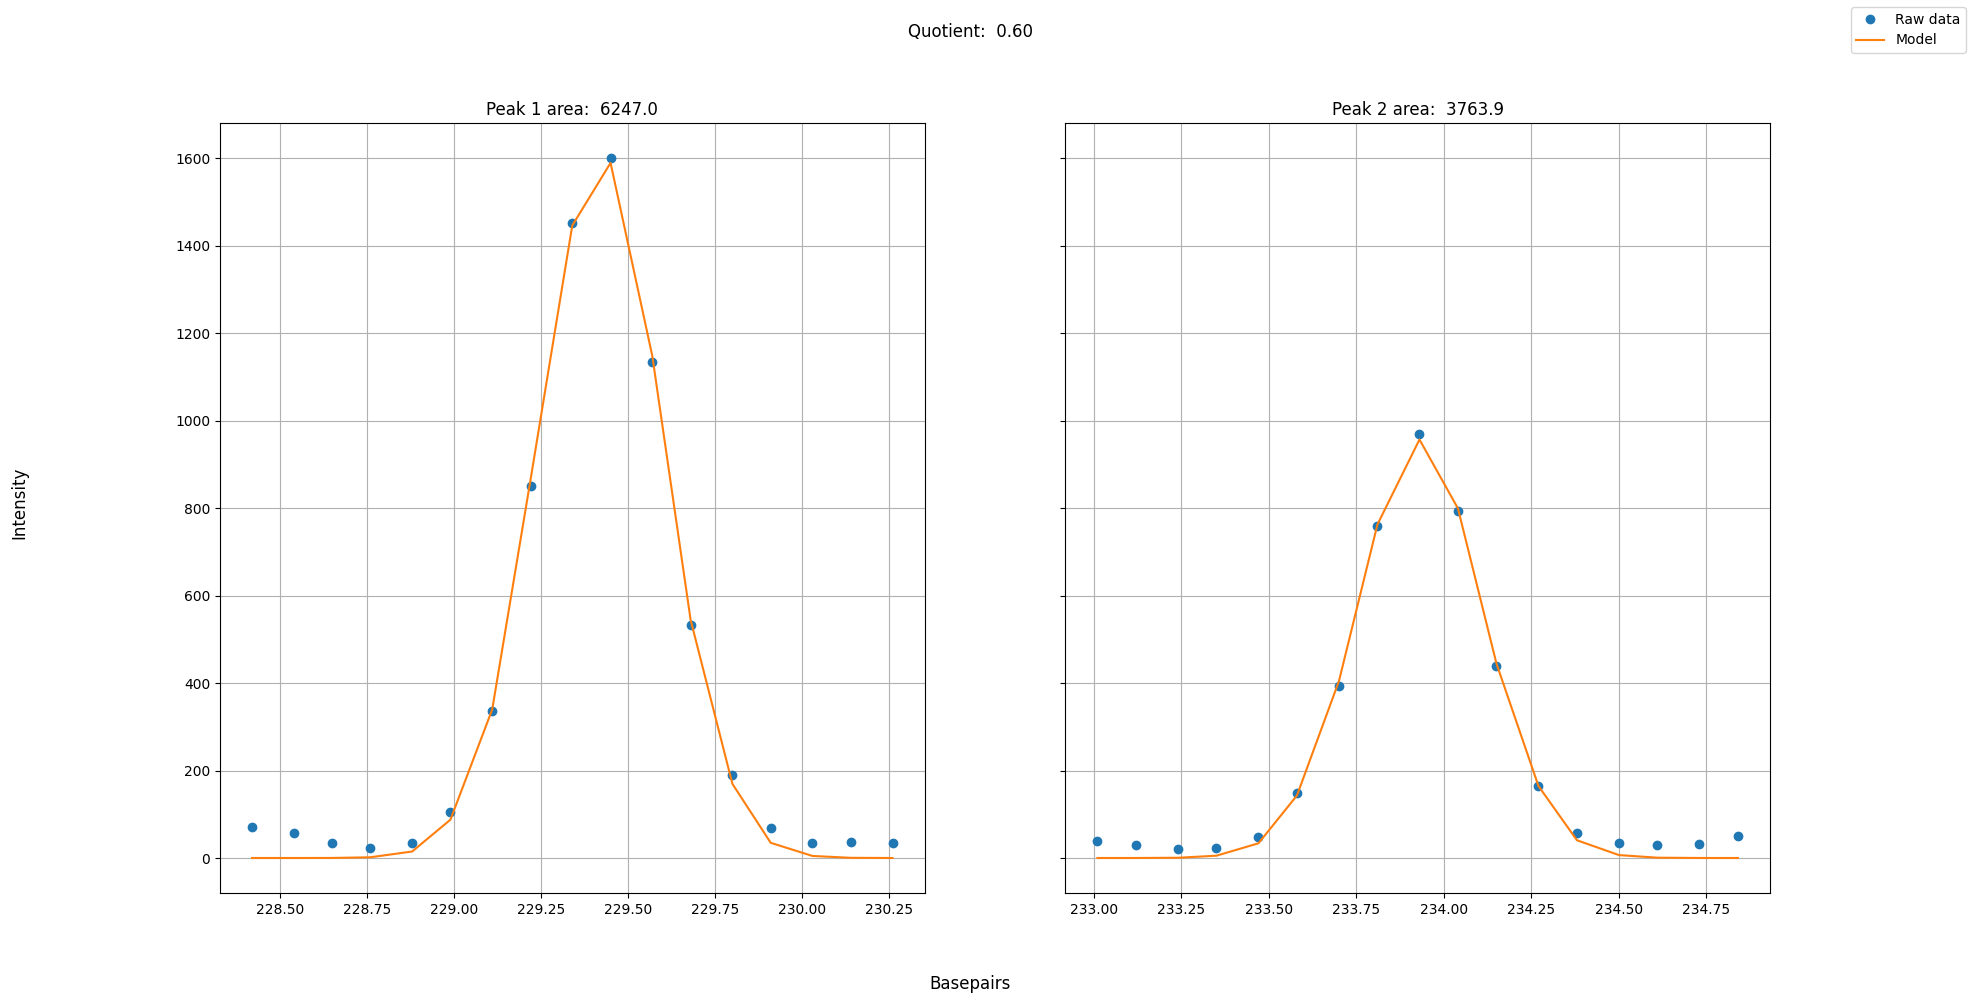

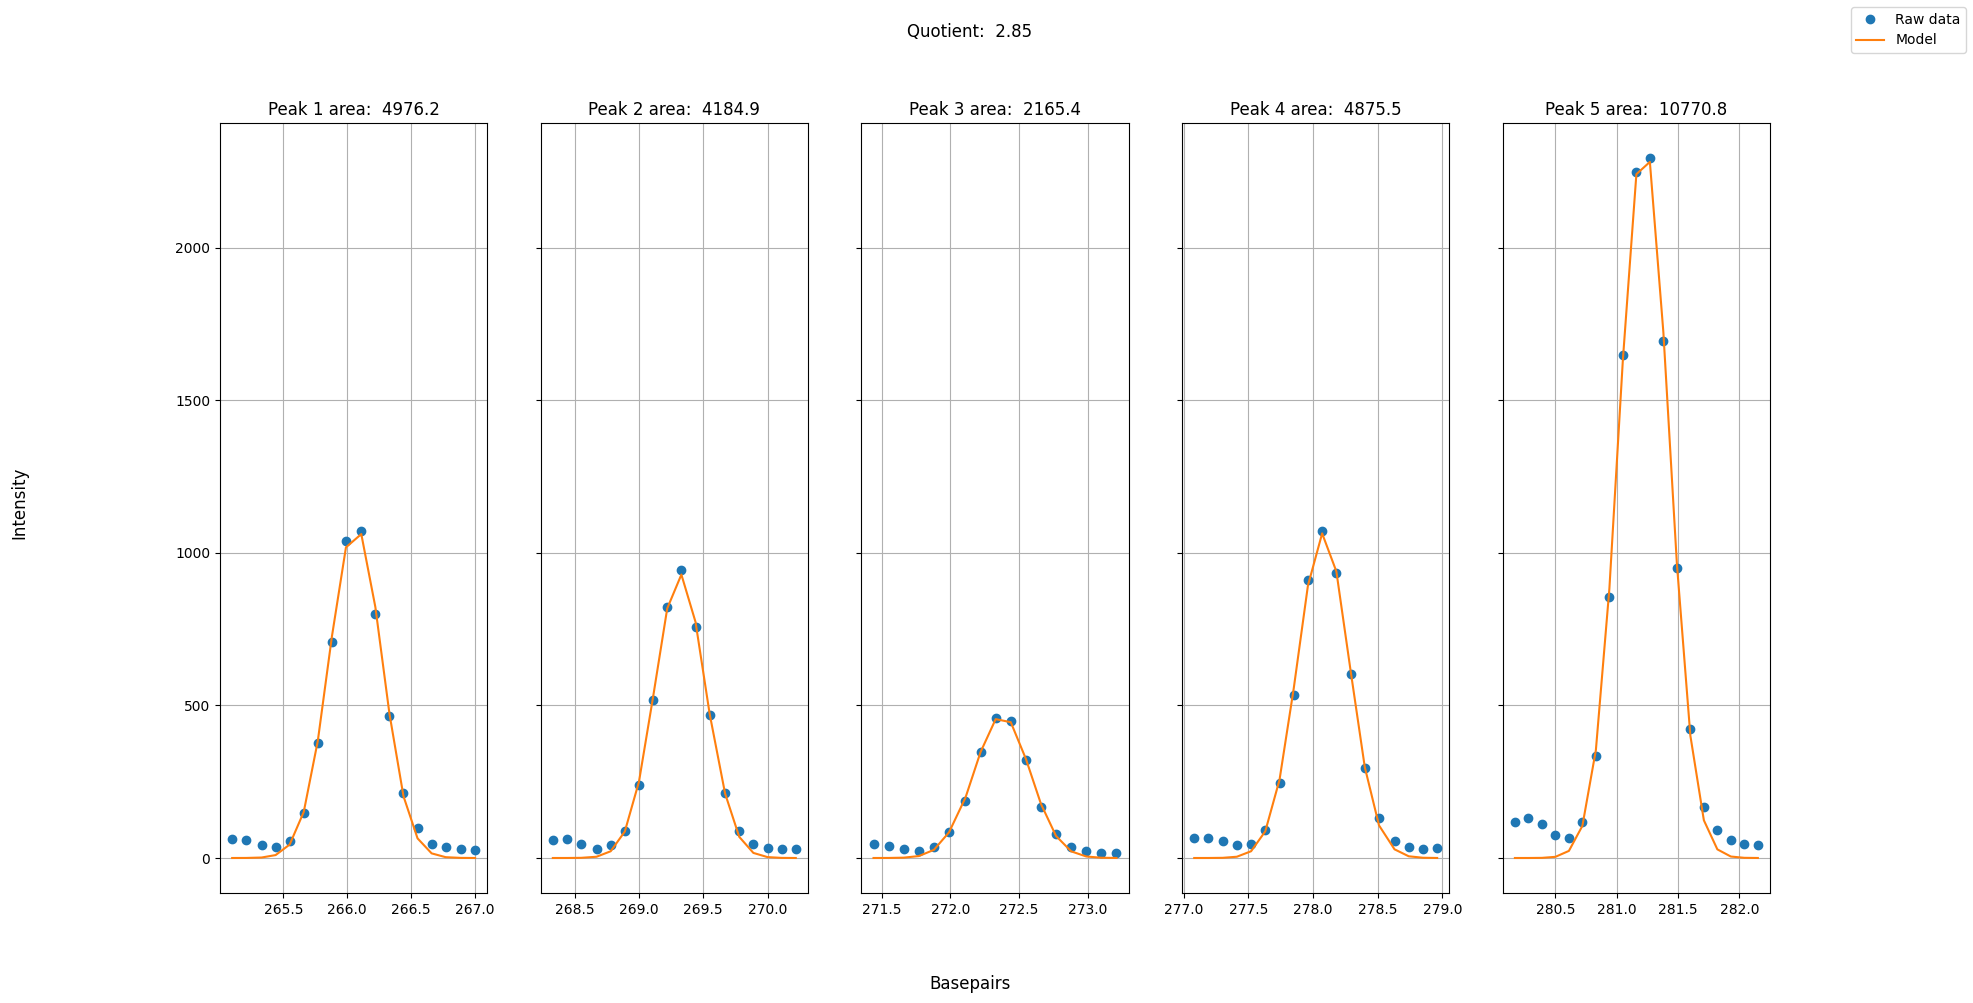

In [27]:
area_plots_list = fraggler.plot_areas(fsa)
for i, plot in enumerate(area_plots_list):
    display(plot)

In [28]:
for plot, name in fraggler.plot_fsa_data(fsa):
    display(plot)
    break


alt.Chart(...)